# Synthetic Datasets - Translated Histograms

- arXiv: Aufenberg, Bresch, Melnyiek, Steidl: xxx

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import importlib

import scanpy as sc
import wsingular
import wsingular_new
importlib.reload(wsingular_new)
from wsingular_new import *

import linear_wasserstein
importlib.reload(linear_wasserstein)
from linear_wasserstein import *

import kernel_wasserstein
importlib.reload(kernel_wasserstein)
from kernel_wasserstein import *

import datetime
import time

from sklearn.metrics import silhouette_score
from torch.utils.tensorboard import SummaryWriter

2025-07-08 11:18:19.999669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


generating functions for $X_i, i \in \{1,2,3\}$

In [2]:
def h_1(x, sigma):
    return np.exp(-np.abs(x)**2/sigma**2) + np.exp(-np.abs(x-1)**2/sigma**2) + np.exp(-np.abs(x+1)**2/sigma**2)

def h_2(x, sigma):
    return h_1(x, sigma) + 1/2*h_1(x + 1/2, sigma)

def h_3(x, sigma):
    return h_1(x, sigma) + 1/2*h_1(x + 1/3, sigma)

define the datasets $X_i \in \R^{n \times m}$

In [3]:
number_samples = 100
number_features = 80

x_samples = np.linspace(1,number_samples,number_samples)/number_samples
y_features = np.linspace(1,number_features,number_features)/number_features

X_dom = np.zeros((number_samples, number_features))
for i in range(0,number_samples):
    for j in range(0,number_features):
        X_dom[i,j] = x_samples[i] - y_features[j]

In [4]:
X_1 = h_1(X_dom, 0.05)
X_2 = h_2(X_dom, 0.05)
X_3 = h_3(X_dom, 0.05)

normalization

In [5]:
A_1 = X_1 / np.max(X_1, axis=0, keepdims=True)
A_2 = X_2 / np.max(X_2, axis=0, keepdims=True)
A_3 = X_3 / np.max(X_3, axis=0, keepdims=True)

B_1 = X_1 / np.max(X_1, axis=1, keepdims=True)
B_2 = X_2 / np.max(X_2, axis=1, keepdims=True)
B_3 = X_3 / np.max(X_3, axis=1, keepdims=True)

In [6]:
A_1, B_1 = wsingular.utils.normalize_dataset(torch.tensor(X_1, dtype=torch.double), normalization_steps=10, dtype=torch.double, device='cpu')
A_2, B_2 = wsingular.utils.normalize_dataset(torch.tensor(X_2, dtype=torch.double), normalization_steps=10, dtype=torch.double, device='cpu')
A_3, B_3 = wsingular.utils.normalize_dataset(torch.tensor(X_3, dtype=torch.double), normalization_steps=10, dtype=torch.double, device='cpu')

In [7]:
writer = SummaryWriter()
import os

str_time = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
path = 'saved/' + str_time 
if not os.path.exists(path):
    os.makedirs(path)

In [365]:
A_WEV, B_WEV = wsingular_new.wasserstein_singular_vectors_seq_step(dataset = A_3,  
                                            label       = None,
                                            dtype        = torch.double, 
                                            device       = 'cpu',
                                            n_iter       = 20,
                                            tau          = 1e-2,
                                            alpha        = 0.9,
                                            gamma_C      = 0.75,
                                            gamma_D      = 0.75,
                                            writer       = writer,
                                            #normalization_steps=100,
                                            progress_bar = True) 

  0%|          | 0/4950 [00:00<?, ?it/s]

In [ ]:
A_SEV, B_SEV = wsingular_new.sinkhorn_singular_vectors_seq_step(dataset = A_3,  
                                            label       = None,
                                            dtype        = torch.double, 
                                            device       = 'cpu',
                                            n_iter       = 20,
                                            tau          = 1e-2,
                                            alpha        = 0.9,
                                            gamma_C      = 0.75,
                                            gamma_D      = 0.75,
                                            writer       = writer,
                                            #normalization_steps=100,
                                            progress_bar = True) 

  0%|          | 0/4950 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
                                                    

Stopping early after keyboard interrupt!


In [8]:
A_SEV_norm, B_SEV_norm = wsingular_new.sinkhorn_singular_vectors_seq_norm(dataset = A_3,  
                                            label       = None,
                                            dtype        = torch.double, 
                                            device       = 'cpu',
                                            n_iter       = 0,
                                            tau          = 1e-2,
                                            writer       = writer,
                                            #normalization_steps=100,
                                            progress_bar = True) 

tensor(1.9665, dtype=torch.float64)
tensor(2.4575, dtype=torch.float64)


In [464]:
A_WEV_norm, B_WEV_norm = wsingular_new.wasserstein_singular_vectors_seq_norm(dataset = A_3,  
                                            label       = None,
                                            dtype        = torch.double, 
                                            device       = 'cpu',
                                            n_iter       = 20,
                                            tau          = 1e-2,
                                            writer       = writer,
                                            #normalization_steps=100,
                                            progress_bar = True) 

In [391]:
tau_A = 0
tau_B = 0
A_lin, B_lin, iteration = linear_wasserstein.unsupervised_lin_learning(dataset            = A_3, 
                                            label                   = None,
                                            dtype                   = torch.double, 
                                            device                  = 'cpu',
                                            regularize              = True,
                                            writer                  = writer,
                                            tau_A                   = tau_A, 
                                            tau_B                   = tau_B, 
                                            relative_residual       = 1e-10,
                                            #normalization_steps     = 100,
                                            iter_max                = 10)

distA_lin = linear_wasserstein.calculate_final_distance_matrix(A_lin, A_3, dtype=torch.double)
distB_lin = linear_wasserstein.calculate_final_distance_matrix(B_lin, A_3.T, dtype=torch.double)

distA_lin_norm = distA_lin - np.diag(np.diag(distA_lin))
distB_lin_norm = distB_lin - np.diag(np.diag(distB_lin))

tensor(1., dtype=torch.float64) tensor(-0.0165, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(-0.0132, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(-0.0165, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(-0.0132, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(-0.0165, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(-0.0132, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(-0.0165, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(-0.0132, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(-0.0165, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(-0.0132, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(-0.0165, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(-0.0132, dtype=torch.float64)


In [392]:
tau_A = 0
tau_B = 0
A_lin, B_lin, iteration = linear_wasserstein.unsupervised_lin_learning_step(dataset            = A_3, 
                                            label                   = None,
                                            dtype                   = torch.double, 
                                            alpha                   = 0.9,
                                            gamma_A                 = 0.01,
                                            gamma_B                 = 0.01,
                                            device                  = 'cpu',
                                            regularize              = False,
                                            writer                  = writer,
                                            tau_A                   = tau_A, 
                                            tau_B                   = tau_B, 
                                            relative_residual       = 1e-10,
                                            #normalization_steps     = 100,
                                            iter_max                = 10)

distA_lin = linear_wasserstein.calculate_final_distance_matrix(A_lin, A_3, dtype=torch.double)
distB_lin = linear_wasserstein.calculate_final_distance_matrix(B_lin, A_3.T, dtype=torch.double)

distA_lin = distA_lin - np.diag(np.diag(distA_lin))
distB_lin = distB_lin - np.diag(np.diag(distB_lin))

In [371]:
rbf_sigma_A = 1
rbf_sigma_B = 1

A_kernel, B_kernel, iteration = kernel_wasserstein.unsupervised_gauss_kernel_learning_norm(dataset              = A_3, 
                                            label                   = None,
                                            dtype                   = torch.double,
                                            device                  = 'cpu',
                                            rbf_sigma_A             = rbf_sigma_A,
                                            rbf_sigma_B             = rbf_sigma_B,
                                            func_kernel_A           = lambda x, y, mat: kernel_wasserstein.rbf_kernel(x, y, mat, rbf_sigma_A), 
                                            func_kernel_B           = lambda x, y, mat: kernel_wasserstein.rbf_kernel(x, y, mat, rbf_sigma_B),
                                            writer                  = writer,
                                            regularize              = True,
                                            #normalization_steps     = 100,
                                            lipschitz_of_kernel_A   = 1 / (2 * rbf_sigma_A ** 2),
                                            lipschitz_of_kernel_B   = 1 / (2 * rbf_sigma_B ** 2),
                                            regularization_param    = 1e-2,
                                            iter_max                = 10,
                                            relative_residual       = 1e-10)

distA_kernel_norm_1_1 = kernel_wasserstein.calculate_final_distance_matrix(A_kernel, A_3, dtype=torch.double)
distB_kernel_norm_1_1 = kernel_wasserstein.calculate_final_distance_matrix(B_kernel, A_3.T, dtype=torch.double)

In [372]:
rbf_sigma_A = 1
rbf_sigma_B = 1

A_kernel, B_kernel, iteration = kernel_wasserstein.unsupervised_gauss_kernel_learning_seq_step(dataset              = A_3, 
                                            label                   = None,
                                            dtype                   = torch.double,
                                            device                  = 'cpu',
                                            rbf_sigma_A             = rbf_sigma_A,
                                            rbf_sigma_B             = rbf_sigma_B,
                                            alpha                   = 0.9,
                                            gamma_A                 = 0.1,
                                            gamma_B                 = 0.1,          
                                            func_kernel_A           = lambda x, y, mat: kernel_wasserstein.rbf_kernel(x, y, mat, rbf_sigma_A), 
                                            func_kernel_B           = lambda x, y, mat: kernel_wasserstein.rbf_kernel(x, y, mat, rbf_sigma_B),
                                            writer                  = writer,
                                            regularize              = True,
                                            #normalization_steps     = 100,
                                            lipschitz_of_kernel_A   = 1 / (2 * rbf_sigma_A ** 2),
                                            lipschitz_of_kernel_B   = 1 / (2 * rbf_sigma_B ** 2),
                                            regularization_param    = 1e-2,
                                            iter_max                = 10,
                                            relative_residual       = 1e-10)

distA_kernel_1_1 = kernel_wasserstein.calculate_final_distance_matrix(A_kernel, A_3, dtype=torch.double)
distB_kernel_1_1 = kernel_wasserstein.calculate_final_distance_matrix(B_kernel, A_3.T, dtype=torch.double)

In [208]:
rbf_sigma_A = 10
rbf_sigma_B = 1

A_sinc, B_sinc, iteration = kernel_wasserstein.unsupervised_gauss_kernel_learning_seq_step(dataset              = A_3, 
                                            label                   = None,
                                            dtype                   = torch.double,
                                            device                  = 'cpu',
                                            rbf_sigma_A             = rbf_sigma_A,
                                            rbf_sigma_B             = rbf_sigma_B,
                                            alpha                   = 0.9,
                                            gamma_A                 = 0.1,
                                            gamma_B                 = 0.1,          
                                            func_kernel_A           = lambda x, y, mat: kernel_wasserstein.sinc_kernel(x, y, mat, rbf_sigma_A), 
                                            func_kernel_B           = lambda x, y, mat: kernel_wasserstein.sinc_kernel(x, y, mat, rbf_sigma_B),
                                            writer                  = writer,
                                            regularize              = True,
                                            #normalization_steps     = 100,
                                            lipschitz_of_kernel_A   = 1 / (2 * rbf_sigma_A ** 2),
                                            lipschitz_of_kernel_B   = 1 / (2 * rbf_sigma_B ** 2),
                                            regularization_param    = 1e-2,
                                            iter_max                = 10,
                                            relative_residual       = 1e-10)

distA_sinc = kernel_wasserstein.calculate_final_distance_matrix(A_kernel, A_3, dtype=torch.double)
distB_sinc = kernel_wasserstein.calculate_final_distance_matrix(B_kernel, A_3.T, dtype=torch.double)

In [209]:
sinc_sigma_A = 10
sinc_sigma_B = 1

A_sinc_norm, B_sinc_norm, iteration = kernel_wasserstein.unsupervised_gauss_kernel_learning_norm(dataset              = A_3, 
                                            label                   = None,
                                            dtype                   = torch.double,
                                            device                  = 'cpu',
                                            rbf_sigma_A             = sinc_sigma_A,
                                            rbf_sigma_B             = sinc_sigma_A,        
                                            func_kernel_A           = lambda x, y, mat: kernel_wasserstein.sinc_kernel(x, y, mat, sinc_sigma_A), 
                                            func_kernel_B           = lambda x, y, mat: kernel_wasserstein.sinc_kernel(x, y, mat, sinc_sigma_A),
                                            writer                  = writer,
                                            regularize              = True,
                                            #normalization_steps     = 100,
                                            lipschitz_of_kernel_A   = 1 / (2 * sinc_sigma_A ** 2),
                                            lipschitz_of_kernel_B   = 1 / (2 * sinc_sigma_A ** 2),
                                            regularization_param    = 1e-2,
                                            iter_max                = 10,
                                            relative_residual       = 1e-10)

distA_sinc_norm = kernel_wasserstein.calculate_final_distance_matrix(A_sinc, A_3, dtype=torch.double)
distB_sinc_norm = kernel_wasserstein.calculate_final_distance_matrix(B_sinc, A_3.T, dtype=torch.double)

In [373]:
distA_eucl = linear_wasserstein.calculate_final_distance_matrix(np.eye(80), A_3, dtype=torch.double)
distB_eucl = linear_wasserstein.calculate_final_distance_matrix(np.eye(100), A_3.T, dtype=torch.double)

In [128]:
writer.close()

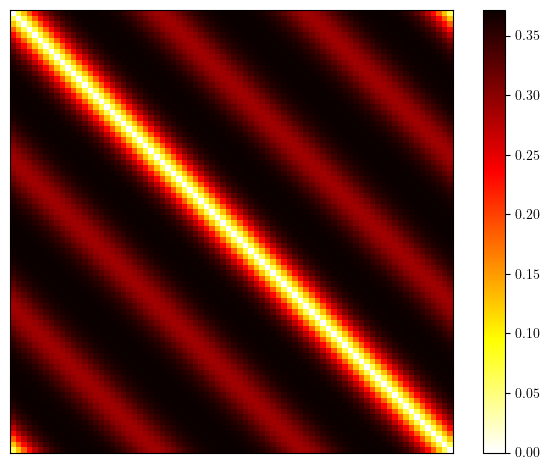

In [395]:
plt.imshow(distB_eucl, cmap='hot_r')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('dist_eucl_A3.pdf', dpi=100)

In [ ]:
from scipy.interpolate import interp1d
interp_func = interp1d(np.linspace(0, 1, 80), A_SEV[19,:], kind='linear')
A_SEV_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_SEV_step.csv", A_SEV_fine, delimiter=",", fmt="%.4f")
interp_func = interp1d(np.linspace(0, 1, 80), A_WEV[19,:], kind='linear')
A_WEV_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_WEV_step.csv", A_WEV_fine, delimiter=",", fmt="%.4f")
interp_func = interp1d(np.linspace(0, 1, 80), distB_kernel_1_1[19,:], kind='linear')
distB_kernel_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_kernel_RBF_step.csv", distB_kernel_fine, delimiter=",", fmt="%.4f")
interp_func = interp1d(np.linspace(0, 1, 80), distB_lin[19,:], kind='linear')
distB_lin_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_graph_step.csv", distB_lin_fine, delimiter=",", fmt="%.4f")
interp_func = interp1d(np.linspace(0, 1, 80), A_SEV_norm[19,:], kind='linear')
A_SEV_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_SEV_norm.csv", A_SEV_fine, delimiter=",", fmt="%.4f")
interp_func = interp1d(np.linspace(0, 1, 80), A_WEV_norm[19,:], kind='linear')
A_WEV_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_WEV_norm.csv", A_WEV_fine, delimiter=",", fmt="%.4f")
interp_func = interp1d(np.linspace(0, 1, 80), distB_kernel_norm_1_1[19,:], kind='linear')
distB_kernel_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_kernel_RBF_norm.csv", distB_kernel_fine, delimiter=",", fmt="%.4f")
interp_func = interp1d(np.linspace(0, 1, 80), distB_lin_norm[19,:], kind='linear')
distB_lin_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_graph_norm.csv", distB_lin_fine, delimiter=",", fmt="%.4f")
interp_func = interp1d(np.linspace(0, 1, 80), distB_eucl[19,:], kind='linear')
distA_eucl_fine = interp_func(np.linspace(0, 1, 100))
np.savetxt("synthetic_A2_eucl.csv", distA_eucl_fine, delimiter=",", fmt="%.4f")

np.savetxt("synthetic_A2.csv", A_2, delimiter=",", fmt="%.4f")
np.savetxt("synthetic_B2.csv", B_2, delimiter=",", fmt="%.4f")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Function to plot 3D row-wise functions with filled area
def plot_3d_filled_lines(matrix, elev=30, azim=45):
    num_rows, num_cols = matrix.shape
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Generate row indices as y-coordinates
    y_vals = np.arange(num_rows)

    # Make panes transparent
    ax.xaxis.pane.fill = False # Left pane
    ax.yaxis.pane.fill = False # Right pane
    ax.zaxis.pane.fill = False # Right pane

    ax.zaxis.set_label_position('none')
    ax.zaxis.set_ticks_position('none')

    # Remove grid lines
    ax.grid(False)

    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # Transparent spines
    # ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    # ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Transparent panes
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # No ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    # Loop through each row and plot it in 3D
    for i in range(num_rows):
        if np.mod(i,10)==0:
            x_vals = np.arange(num_cols)  # Column indices as x-coordinates
            z_vals = matrix[i, :].cpu().numpy()  # Row values as z-coordinates
            y_fixed = np.full_like(x_vals, y_vals[i])  # Keep row at a fixed y-position

            # Plot the function as a line
            ax.plot(x_vals, y_fixed, z_vals, label=f'Row {i+1}', lw=2, color='black')

            # Create vertices for the filled area
            verts = [list(zip(x_vals, y_fixed, np.zeros_like(z_vals)))]  # Bottom edge at z=0
            verts[0] += list(zip(x_vals[::-1], y_fixed[::-1], z_vals[::-1]))  # Upper edge (row values)

            # Create and add the polygon for the fill
            poly = Poly3DCollection(verts, color=plt.cm.viridis(i / num_rows), alpha=0.6)
            ax.add_collection3d(poly)

    # Set view angle
    ax.view_init(elev=elev, azim=azim)  # Adjust the camera angle

    # Labels and title
    # ax.set_xlabel('Columns')
    # ax.set_ylabel('Rows')
    # ax.set_zlabel('Value')
    # ax.set_title('3D Line Plot with Filled Area')

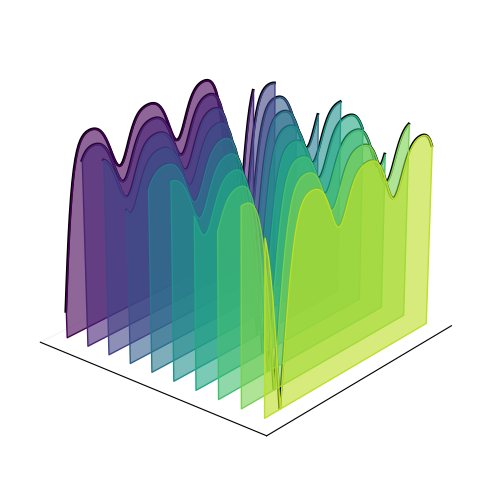

In [285]:
plot_3d_filled_lines(distA_gauss, elev=25, azim=40)
plt.savefig('A3_gauss_1.0_1.0_0.01.pdf', dpi=100)